# Machine learning for biogeographic traits

To predict microbial traits in the unsampled areas, we also implemented several function for machine learning. See the follwoing examples for details.

Here we need three R packages for this section of [microgeo](https://github.com/ChaonanLi/microgeo) R package tutorial. Just run the following codes to import them into R environment.

In [1]:
suppressMessages(require("magrittr")) 
require("ggplot2")  %>% suppressMessages()
require("microgeo") %>% suppressMessages()

If the Chinese characters cannot be displayed correctly, please run the following codes to set locale to `UTF-8`:

In [2]:
prev_locale <- Sys.setlocale("LC_CTYPE", "C.UTF-8") 

We need a standard microgeo dataset for the presentations in the section of tutorial.

In [3]:
# Use the map downloaded from DataV.GeoAtlas
data(qtp)
map <- read_aliyun_map(adcode = c(540000, 630000, 510000)) %>% suppressMessages()
dataset.dts.aliyun <- create_dataset(mat = qtp$asv, ant = qtp$tax, met = qtp$met, map = map,
                                     phy = qtp$tre, env = qtp$env, lon = "longitude", lat = "latitude") 
dataset.dts.aliyun %<>% get_ai(out.dir = "test") 
dataset.dts.aliyun %<>% get_his_bioc(res = 10, out.dir = "test")
dataset.dts.aliyun %<>% get_fut_bioc(res = 10, gcm = "ACCESS-CM2", out.dir = "test")
dataset.dts.aliyun %<>% get_modis_cla_metrics(username = "username", password = "password", measures = "LC_Type1", out.dir = "test") # Please provide correct username and password. 
dataset.dts.aliyun %<>% extract_data_from_spatraster()
dataset.dts.aliyun %<>% rarefy_count_table() 
dataset.dts.aliyun %<>% tidy_dataset()
dataset.dts.aliyun %<>% calc_rel_abund() 
dataset.dts.aliyun %>%  show_dataset()

ℹ [2024-01-14 11:37:25] INFO ==> all samples fall within the map area!

ℹ [2024-01-14 11:37:25] INFO ==> dataset has been created successfully!

ℹ [2024-01-14 11:37:25] INFO ==> use `object %>% show_dataset()` to check the summary of dataset.

✔ [2024-01-14 11:37:30] SAVE ==> results have been saved to: object$spa$rast$his$AI

✔ [2024-01-14 11:37:37] SAVE ==> results have been saved to: object$spa$rast$his(19 variables)

✔ [2024-01-14 11:38:05] SAVE ==> results have been saved to: object$spa$rast$fut [19 variables; 4 groups]

ℹ [2024-01-14 11:38:05] INFO ==> preparing MODIS product list for searching...

ℹ [2024-01-14 11:38:05] INFO ==> searching avaliable MODIS products...

ℹ [2024-01-14 11:38:05] INFO ==> current product (1/1): MCD12Q1 (LC_Type1--> 2022-01-01 to 2022-12-31)

ℹ [2024-01-14 11:38:12] INFO ==> find 8 files with 0.09 GB in total...

ℹ [2024-01-14 11:38:12] INFO ==> downloading all avaliable MODIS products[skip if the file exists]...

ℹ [2024-01-14 11:38:12] INFO ==> prep

── The Summary of Microgeo Dataset ─────────────────────────────────────────────


ℹ object$mat: 6806 ASVs/genes and 1095 samples [subsample depth: 5310]

ℹ object$ant: 6806 ASVs/genes and 7 annotation levels (Kingdom, Phylum, Class, Order, Family, Genus, Species)

ℹ object$met: 1095 samples and 2 variables (longitude, latitude)

ℹ object$map: a SpatialPolygonsDataFrame with the CRS of '+proj=longlat +datum=WGS84 +no_defs'

ℹ object$phy: a phylogenetic tree with 6806 tip labels

ℹ object$env: 1095 samples and 10 variables




── The Summary of Biogeographic Traits ─────────────────────────────────────────


✔ object$spa: 20 historically numeric variables; 1 historically classification variables; 4 groups of future climate data

✔ object$abd$raw: 7 abundance tables (Kingdom, Phylum, Class, Order, Family, Genus, Species)




• To check the summary of dataset, Replace `object` with the variable name of your dataset
• For example, if the variable name is `dataset.dts`you can run `head(dataset.dts$met)` to check the content of `met`


Now, let's go through each of these functions and see how they are used.

## 1. Create a machine learning (ML) model

In [4]:
# Calculate ecological markers at family level
dataset.dts.aliyun %<>% calc_markers(use.dat = 'spa', use.var = 'AI', annotation.level = 'Family', r.thres = 0.3) %>% suppressMessages()

In [5]:
# Check the markers
head(dataset.dts.aliyun$abd$mar$correlation)

var                   r         p           
f__SC.I.84            f__SC.I.84            0.5019584 6.024163e-71
f__A21b               f__A21b               0.4945882 1.274349e-68
f__Nitrosomonadaceae  f__Nitrosomonadaceae  0.4938143 2.219101e-68
f__Phaselicystidaceae f__Phaselicystidaceae 0.4648594 8.491097e-60
f__Desulfarculaceae   f__Desulfarculaceae   0.4507895 6.472780e-56
f__Haliangiaceae      f__Haliangiaceae      0.4327388 3.406709e-51

In [6]:
# Create a regression random forest model for f__SC.I.84
rf.rst.reg <- create_ml_model(y.data = dataset.dts.aliyun$abd$mar$abundance, 
                              x.data = dataset.dts.aliyun$spa$tabs[,paste0("Bio", seq(19))], var = 'f__SC.I.84', method = 'rf')

In [7]:
# Create dataset for binary classification random forest model
family.bins <- data.frame(row.names = rownames(dataset.dts.aliyun$abd$mar$abundance), 
                          f__SC.I.84 = dataset.dts.aliyun$abd$mar$abundance$f__SC.I.84)
family.bins$f__SC.I.84 <- ifelse(family.bins$f__SC.I.84 > 0, "presence", "absence")
family.bins$f__SC.I.84 <- as.factor(family.bins$f__SC.I.84)

In [8]:
# Create a binary classification random forest model
rf.rst.cla.bin <- create_ml_model(y.data = family.bins, x.data = dataset.dts.aliyun$spa$tabs[,paste0("Bio", seq(19))],
                                  var = 'f__SC.I.84', method = 'rf', type = 'classification')

In [9]:
# Create dataset for mutiple class classification random forest model
family.mutiple <- data.frame(row.names = rownames(dataset.dts.aliyun$abd$mar$abundance), 
                             f__SC.I.84 = dataset.dts.aliyun$abd$mar$abundance$f__SC.I.84)
family.mutiple$f__SC.I.84 <- cut(family.mutiple$f__SC.I.84, breaks = c(-Inf, 0.05, 0.2, 0.9, Inf), labels = c("H", "A", "S", "Y"))
family.mutiple$f__SC.I.84 <- as.factor(family.mutiple$f__SC.I.84)

In [10]:
# Create a mutiple class classification random forest model
rf.rst.cla.mutiple <- create_ml_model(y.data = family.mutiple, x.data = dataset.dts.aliyun$spa$tabs[,paste0("Bio", seq(19))],
                                      var = 'f__SC.I.84', method = 'rf', type = 'classification')

## 2. Evaluate machine learning model

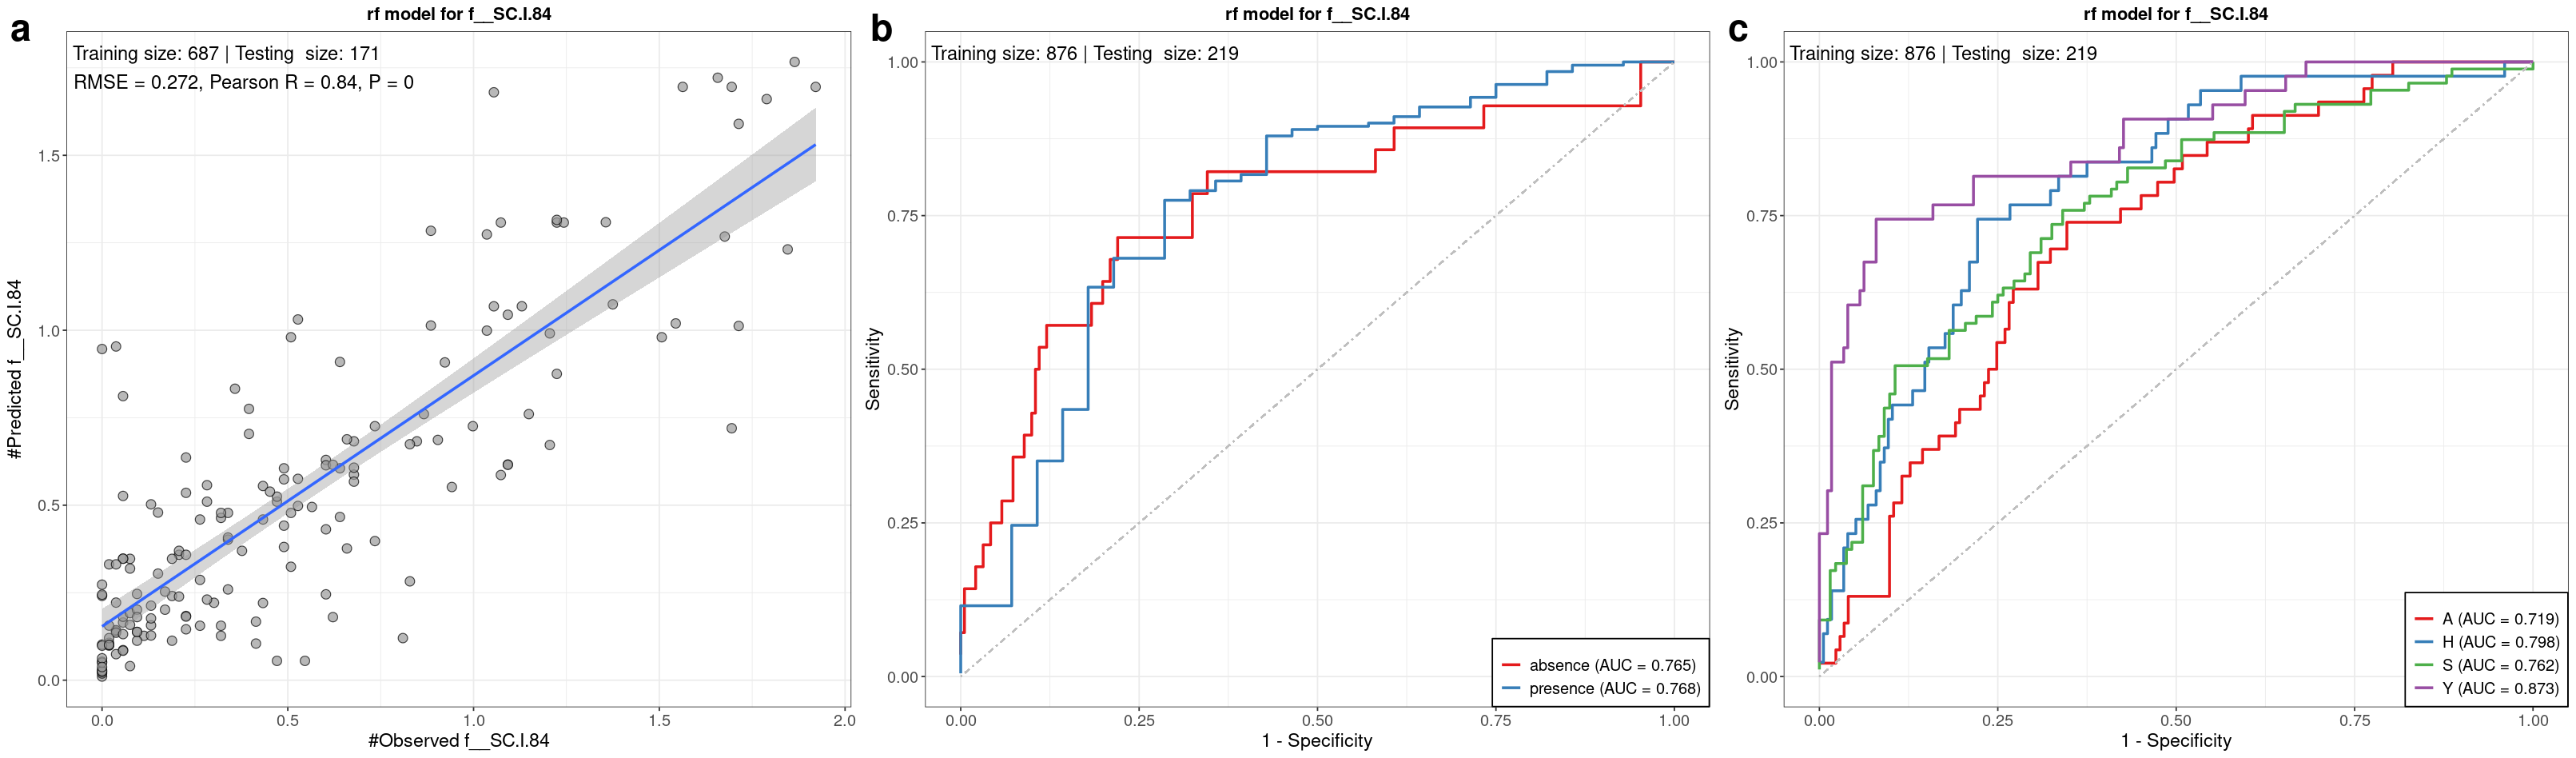

In [11]:
options(repr.plot.width = 13.43 * 2, repr.plot.height = 7.9)
m1 <- rf.rst.reg %>% evaluate_ml_model()
m2 <- rf.rst.cla.bin %>% evaluate_ml_model()
m3 <- rf.rst.cla.mutiple %>% evaluate_ml_model()
cowplot::plot_grid(m1, m2, m3, align = 'hv', ncol = 3, labels = c("a", "b", 'c'), label_size = 28) %>% suppressWarnings()

## 3. Predict values on a geographic map

In [12]:
# Predict f__SC.I.84 based on regression random forest model using historically bioclimatic variables
rf.rst.reg.pred.his <- rf.rst.reg %>%predict_ml_geomap(spat.raster = dataset.dts.aliyun$spa$rast$his[[paste0("Bio", seq(19))]])

In [13]:
# Predict f__SC.I.84 based on regression random forest model using future bioclimatic variables [`ACCESS-CM2|ssp585|2061-2080`]
rf.rst.reg.pred.fut <- rf.rst.reg %>% predict_ml_geomap(spat.raster = dataset.dts.aliyun$spa$rast$fut$`ACCESS-CM2|ssp585|2061-2080`)

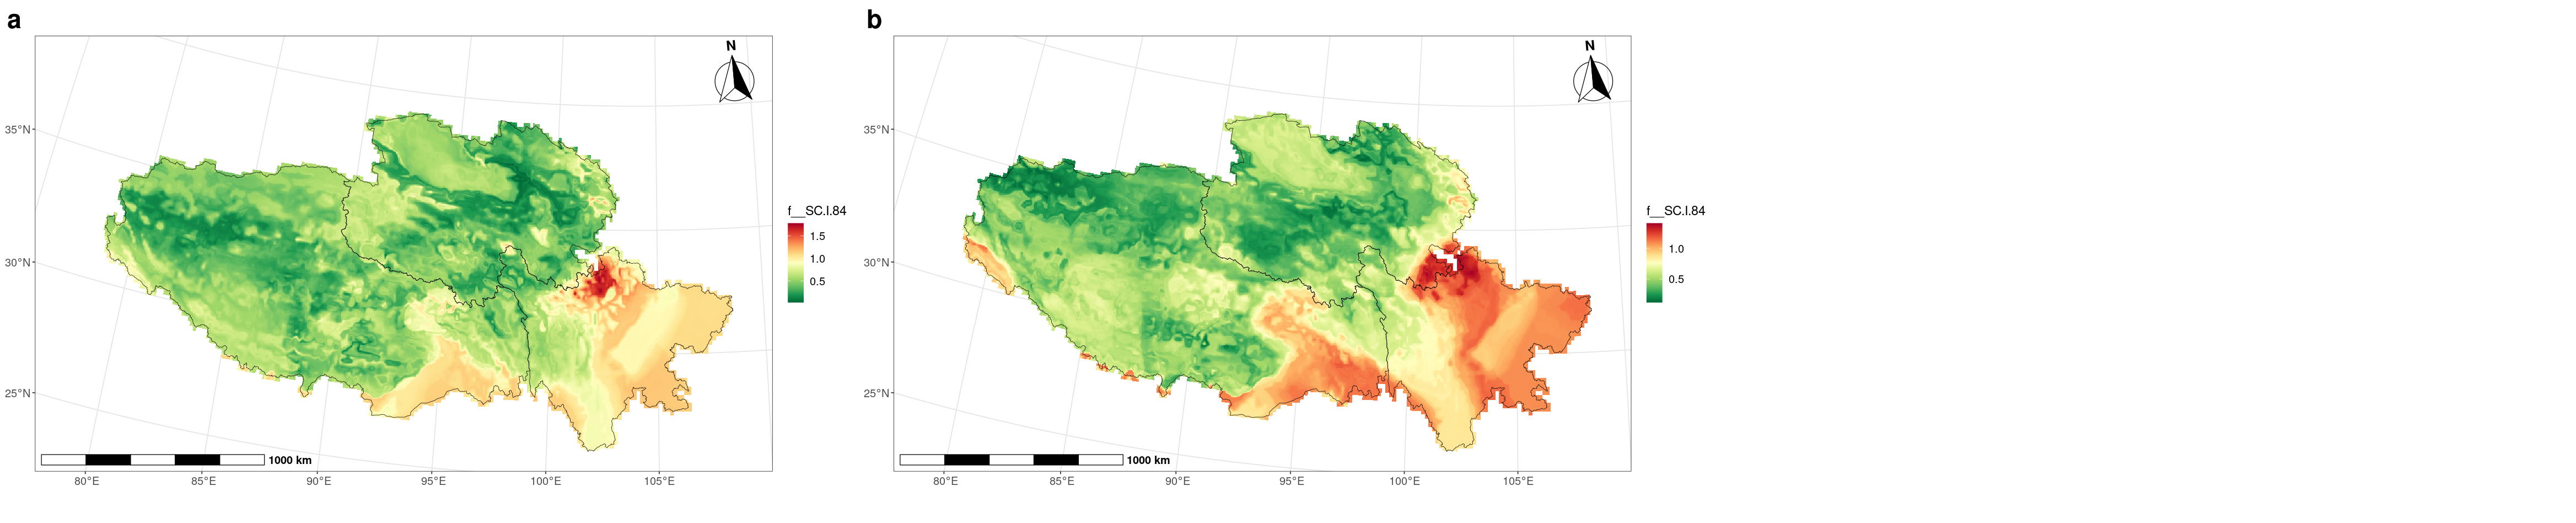

In [14]:
# Show figure 
options(repr.plot.width = 13.43 * 2.9, repr.plot.height = 7.9)
h1 <- plot_bmap(map = dataset.dts.aliyun$map) %>% add_spatraster(spat.raster = rf.rst.reg.pred.his) %>% add_scale_bar() %>% add_north_arrow() %>% add_crs()
h2 <- plot_bmap(map = dataset.dts.aliyun$map) %>% add_spatraster(spat.raster = rf.rst.reg.pred.fut) %>% add_scale_bar() %>% add_north_arrow() %>% add_crs()
cowplot::plot_grid(h1, h2, align = 'hv', ncol = 3, labels = c("a", "b"), label_size = 28) %>% suppressWarnings()

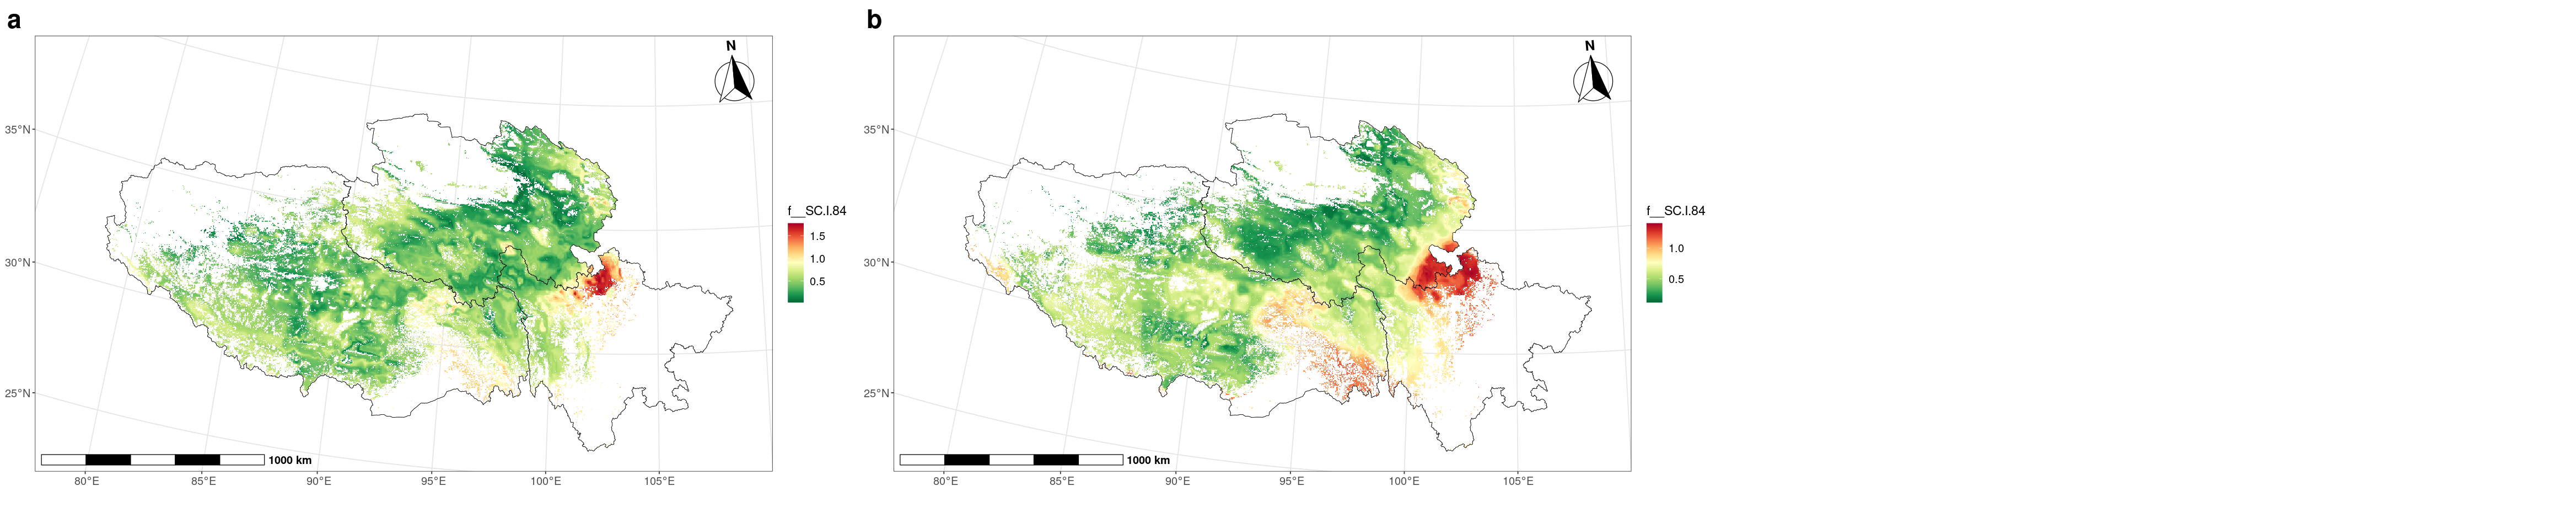

In [15]:
# Mask the predicted results by grassland (10)
options(repr.plot.width = 13.43 * 2.9, repr.plot.height = 7.9)
rf.rst.reg.pred.his.m <- mask_spatraster_by_cla(tar.spat = rf.rst.reg.pred.his, ref.spat = dataset.dts.aliyun$spa$rast$cla$LC_Type1, use.class = 10)
rf.rst.reg.pred.fut.m <- mask_spatraster_by_cla(tar.spat = rf.rst.reg.pred.fut, ref.spat = dataset.dts.aliyun$spa$rast$cla$LC_Type1, use.class = 10)
h3 <- plot_bmap(map = dataset.dts.aliyun$map) %>% add_spatraster(spat.raster = rf.rst.reg.pred.his.m) %>% add_scale_bar() %>% add_north_arrow() %>% add_crs()
h4 <- plot_bmap(map = dataset.dts.aliyun$map) %>% add_spatraster(spat.raster = rf.rst.reg.pred.fut.m) %>% add_scale_bar() %>% add_north_arrow() %>% add_crs()
cowplot::plot_grid(h3, h4, align = 'hv', ncol = 3, labels = c("a", "b"), label_size = 28) %>% suppressWarnings()

In [16]:
# Predict f__SC.I.84 based on binary classification random forest model using historically bioclimatic variables
rf.rst.cla.bin.pred.his <- rf.rst.cla.bin %>% predict_ml_geomap(spat.raster = dataset.dts.aliyun$spa$rast$his[[paste0("Bio", seq(19))]])

In [17]:
# Predict f__SC.I.84 based on binary classification random forest model using future bioclimatic variables [`ACCESS-CM2|ssp585|2061-2080`]
rf.rst.cla.bin.pred.fut <- rf.rst.cla.bin %>% predict_ml_geomap(spat.raster = dataset.dts.aliyun$spa$rast$fut$`ACCESS-CM2|ssp585|2061-2080`)

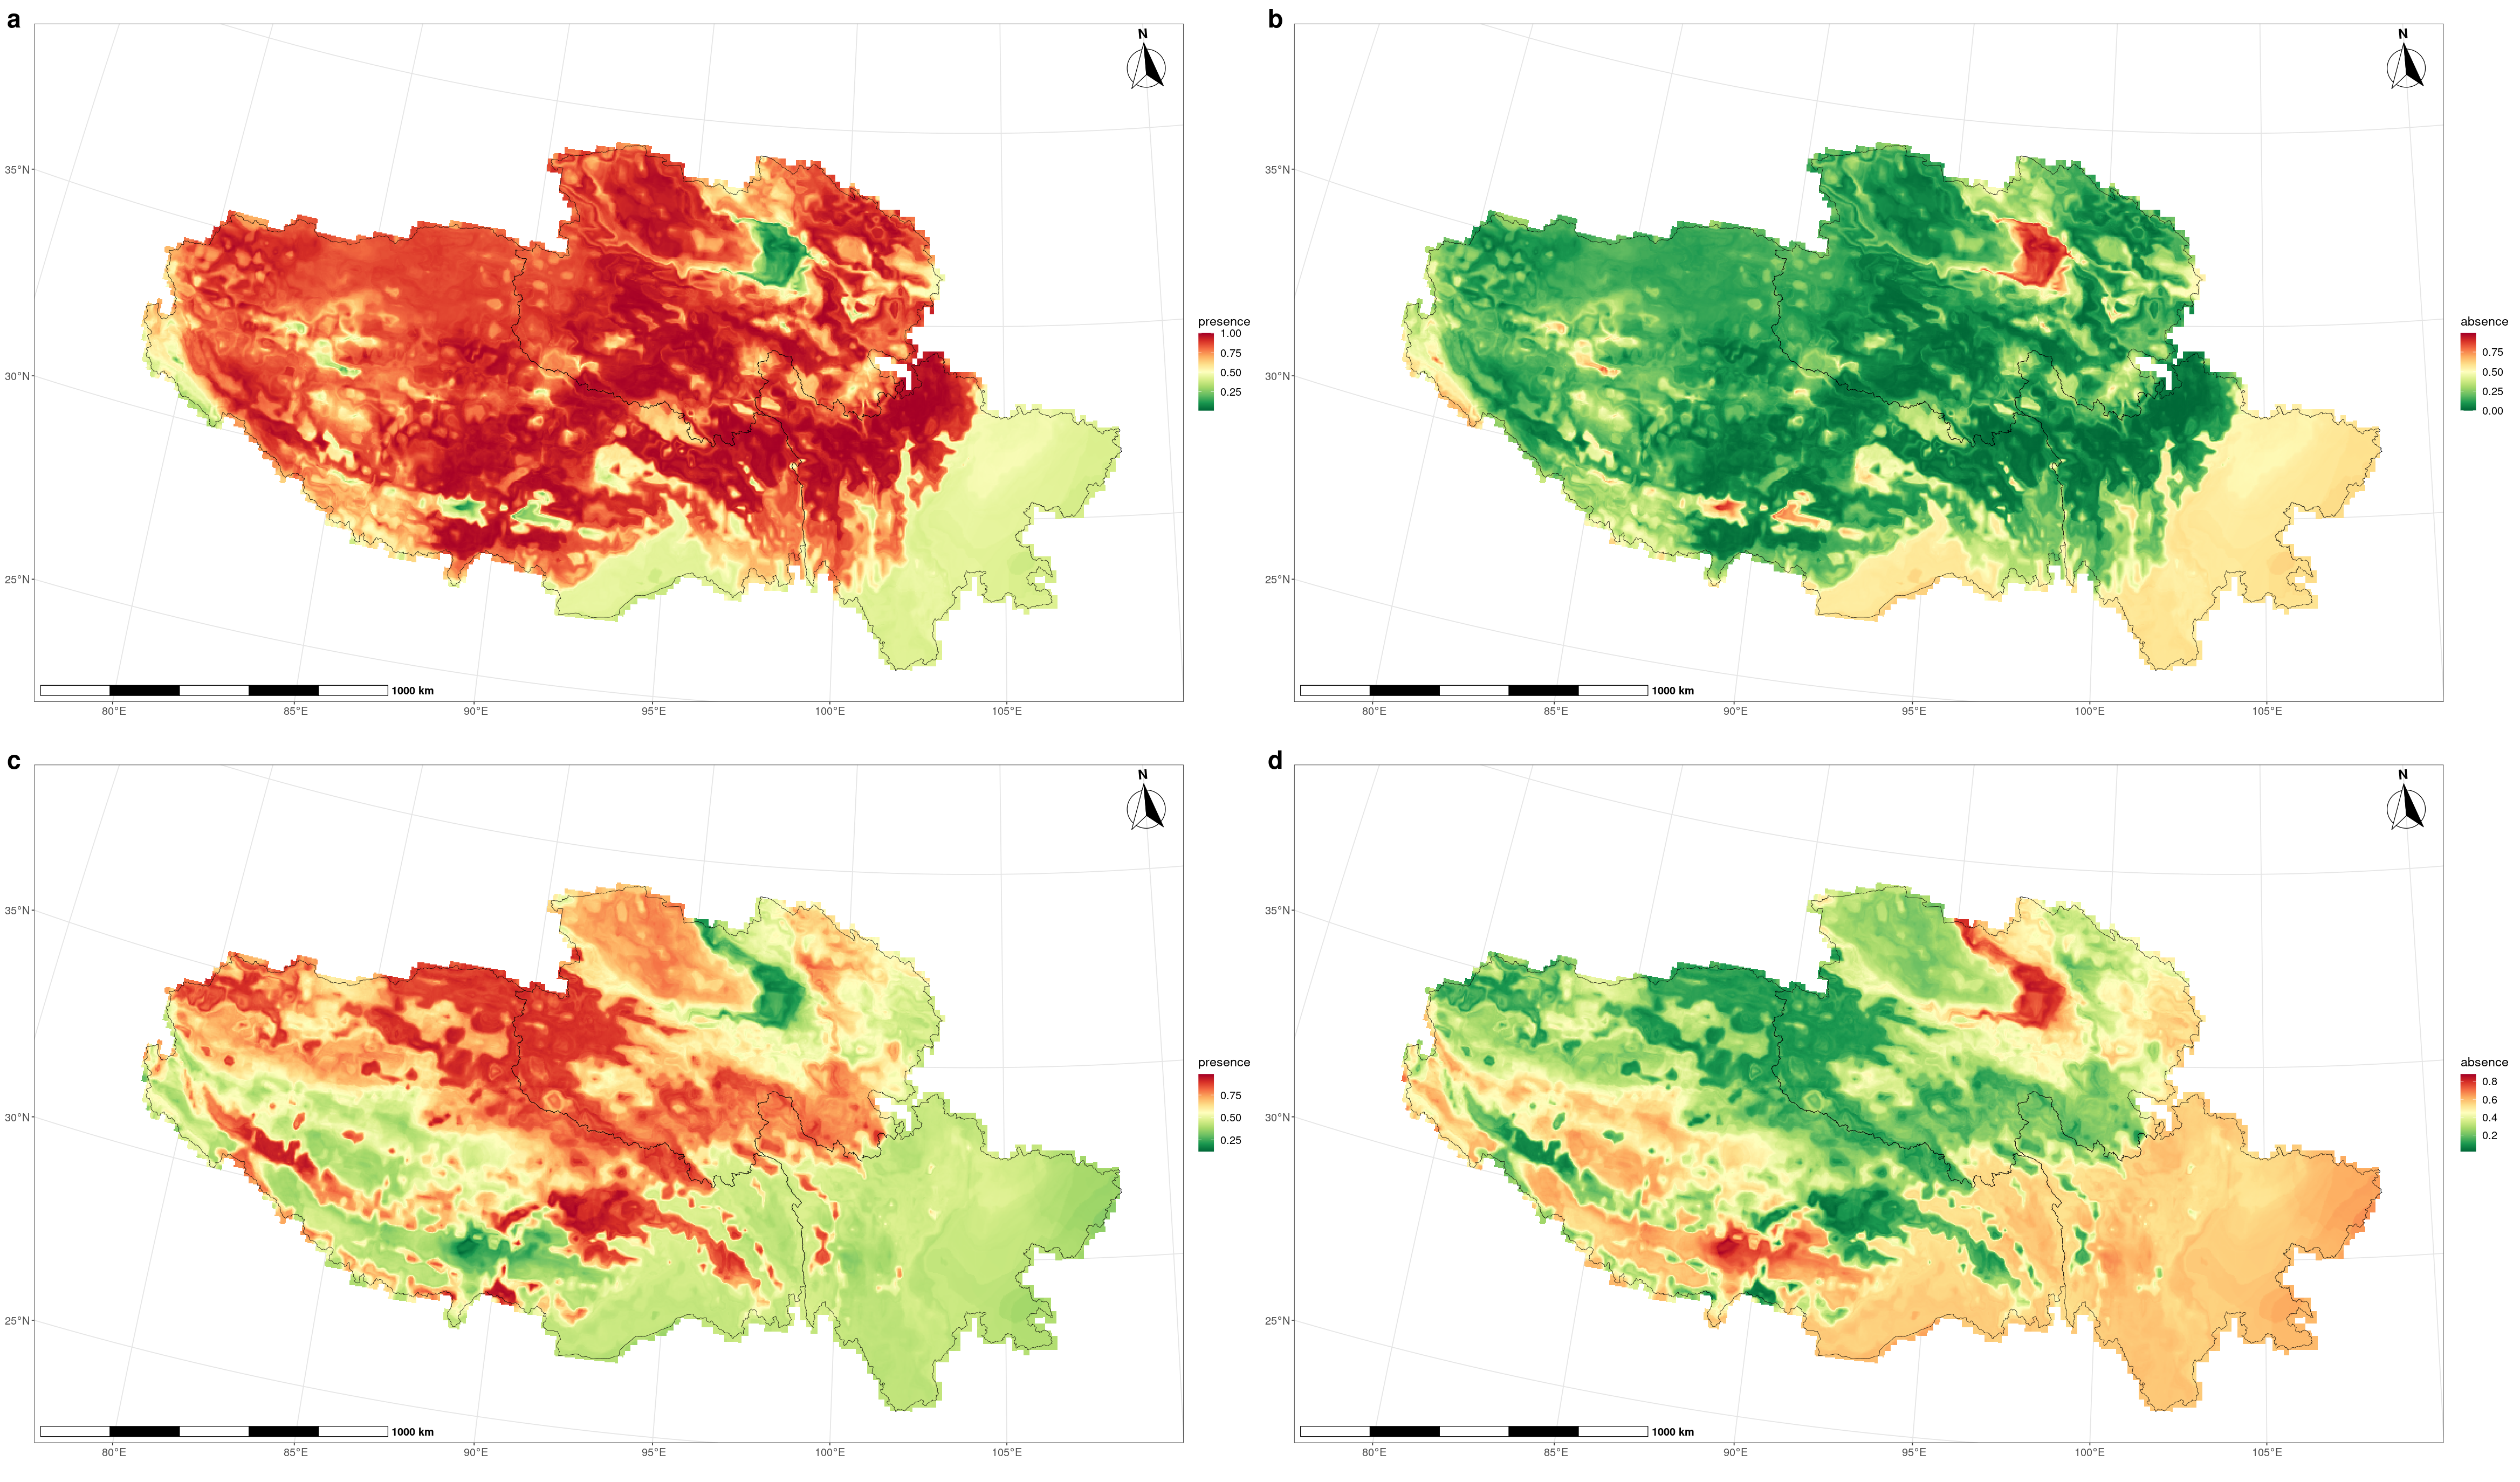

In [18]:
# Show figure 
options(repr.plot.width = 13.43 * 2.9, repr.plot.height = 7.9 * 2.9)
h5 <- plot_bmap(map = dataset.dts.aliyun$map) %>% add_spatraster(spat.raster = rf.rst.cla.bin.pred.his$presence) %>% add_scale_bar() %>% add_north_arrow() %>% add_crs()
h6 <- plot_bmap(map = dataset.dts.aliyun$map) %>% add_spatraster(spat.raster = rf.rst.cla.bin.pred.his$absence) %>% add_scale_bar() %>% add_north_arrow() %>% add_crs()
h7 <- plot_bmap(map = dataset.dts.aliyun$map) %>% add_spatraster(spat.raster = rf.rst.cla.bin.pred.fut$presence) %>% add_scale_bar() %>% add_north_arrow() %>% add_crs()
h8 <- plot_bmap(map = dataset.dts.aliyun$map) %>% add_spatraster(spat.raster = rf.rst.cla.bin.pred.fut$absence) %>% add_scale_bar() %>% add_north_arrow() %>% add_crs()
cowplot::plot_grid(h5, h6, h7, h8, align = 'hv', ncol = 2, labels = c("a", "b", "c", "d"), label_size = 28) %>% suppressWarnings()

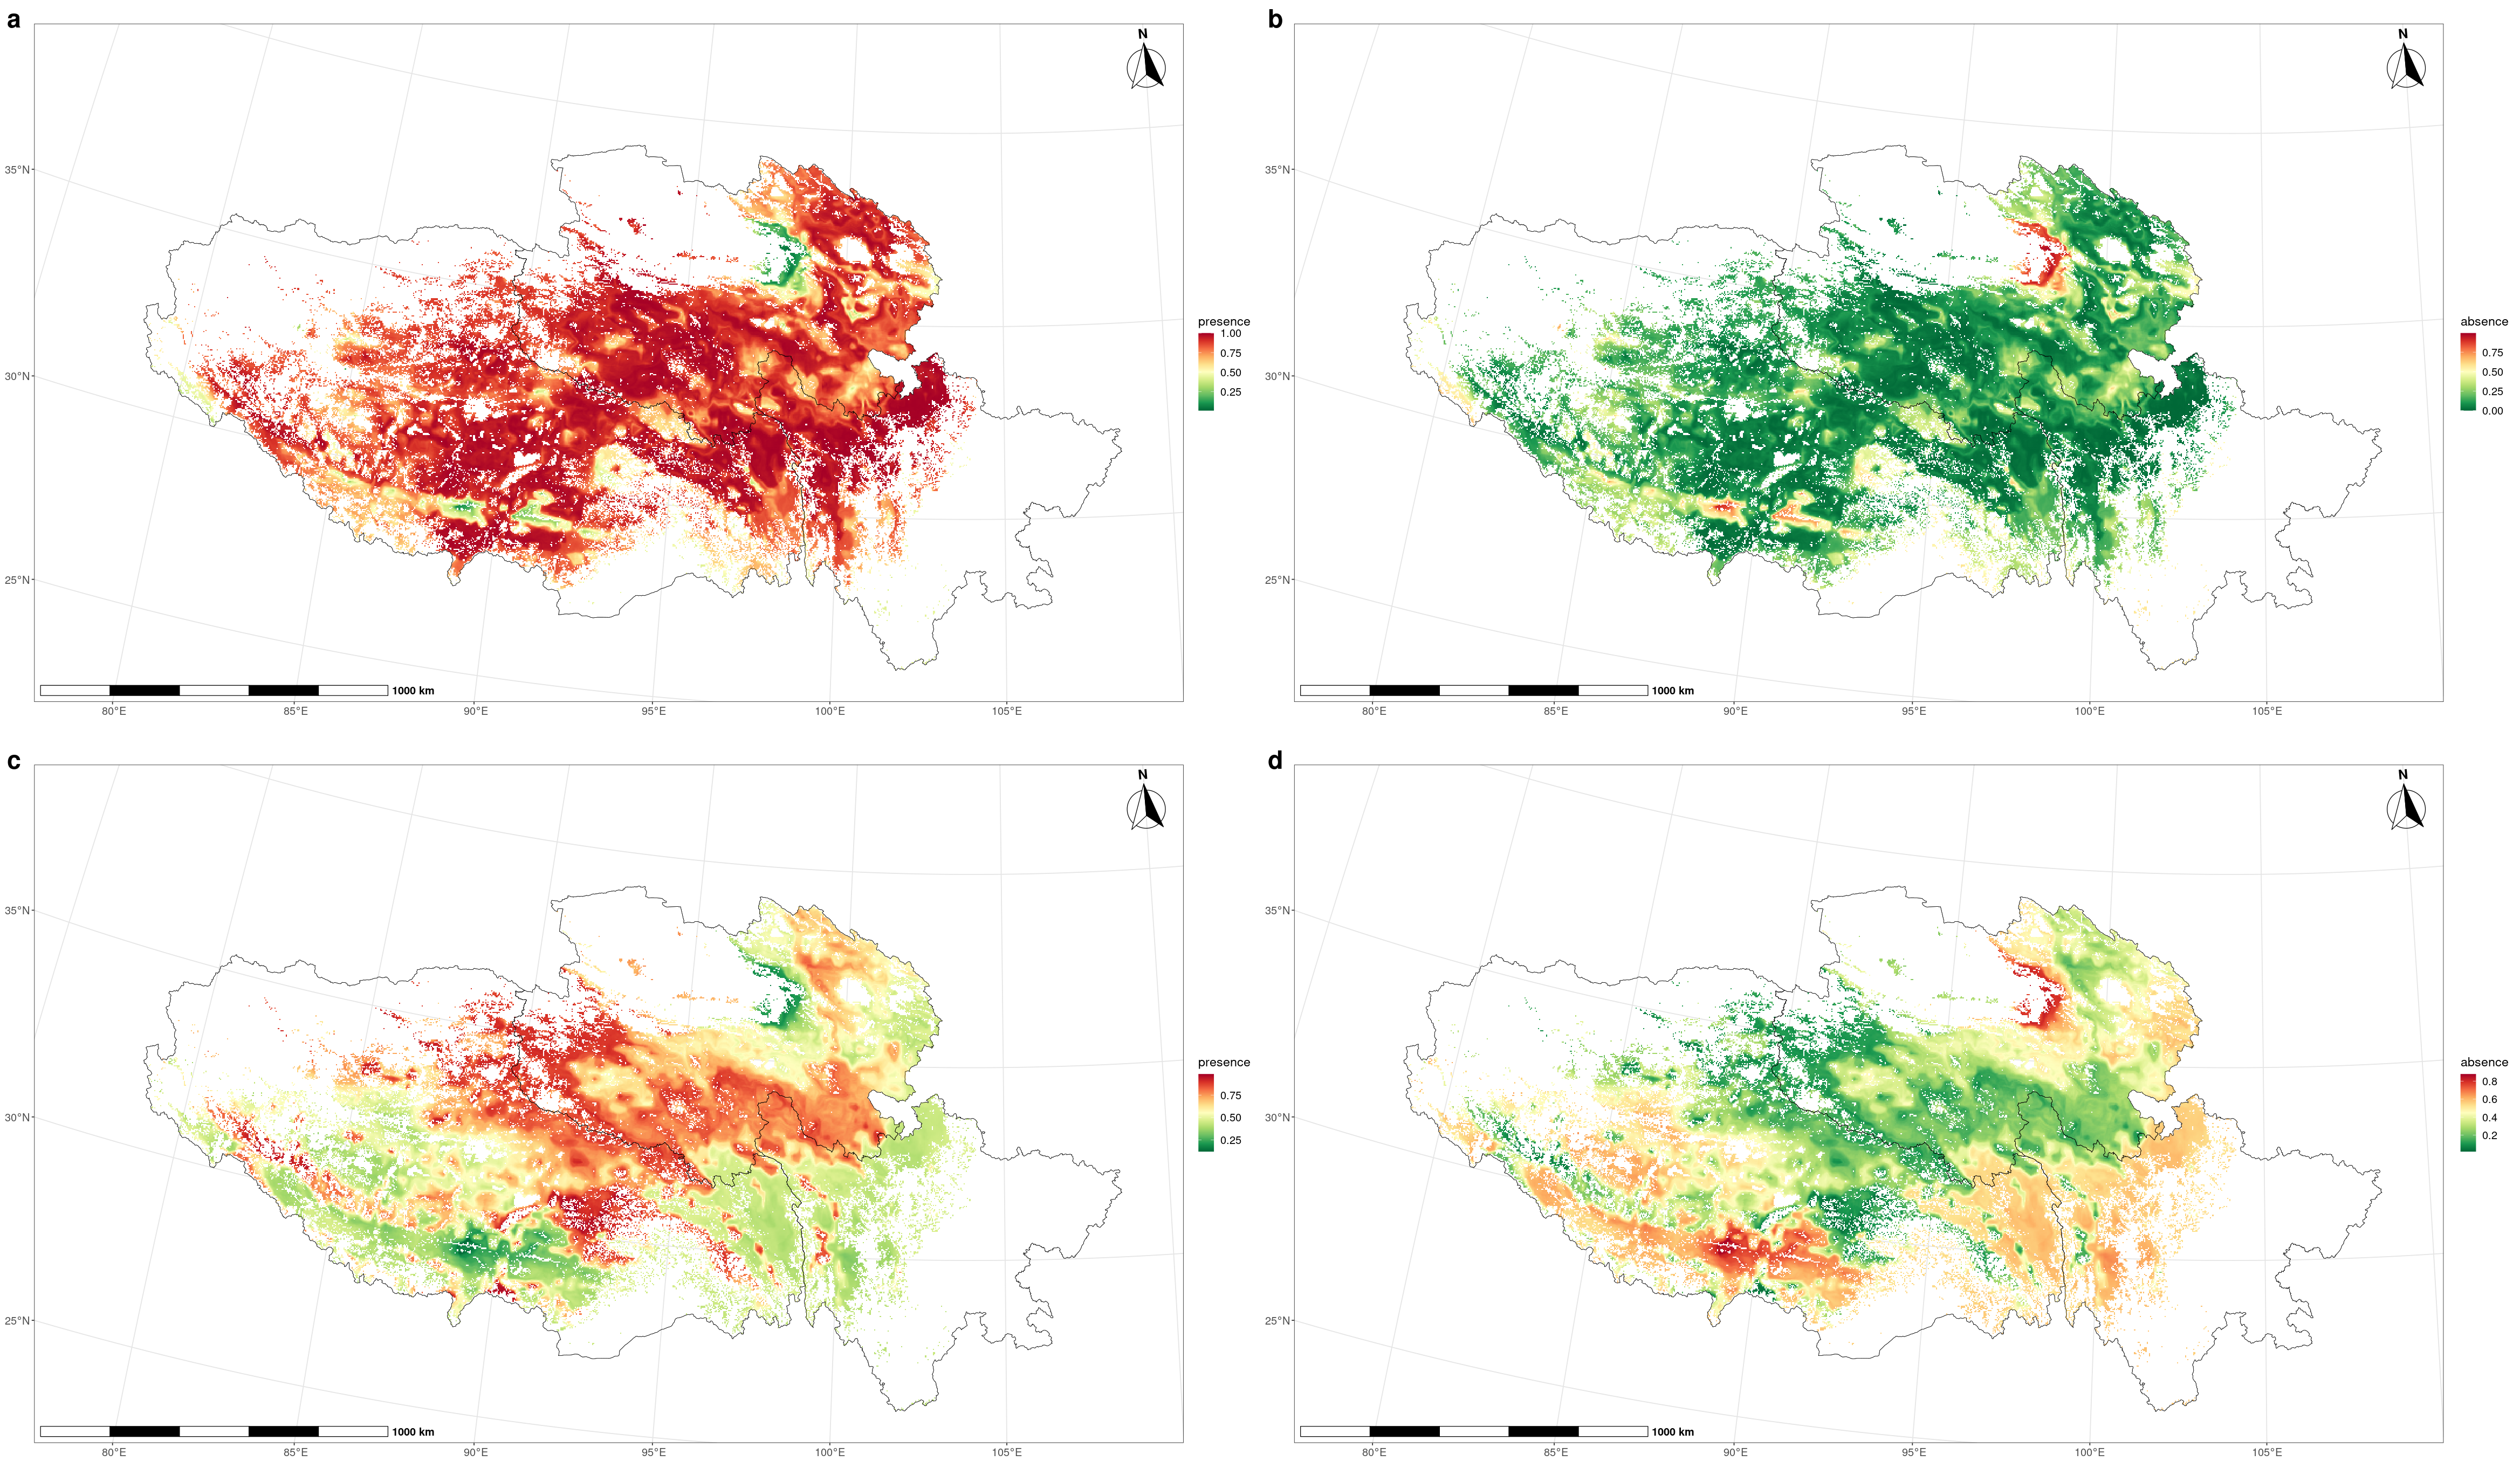

In [19]:
# Mask the predicted results by grassland (10)
options(repr.plot.width = 13.43 * 2.9, repr.plot.height = 7.9 * 2.9)
rf.rst.cla.bin.pred.his.m.p <- mask_spatraster_by_cla(tar.spat = rf.rst.cla.bin.pred.his$presence, ref.spat = dataset.dts.aliyun$spa$rast$cla$LC_Type1, use.class = 10)
rf.rst.cla.bin.pred.his.m.a <- mask_spatraster_by_cla(tar.spat = rf.rst.cla.bin.pred.his$absence, ref.spat = dataset.dts.aliyun$spa$rast$cla$LC_Type1, use.class = 10)
rf.rst.cla.bin.pred.fut.m.p <- mask_spatraster_by_cla(tar.spat = rf.rst.cla.bin.pred.fut$presence, ref.spat = dataset.dts.aliyun$spa$rast$cla$LC_Type1, use.class = 10)
rf.rst.cla.bin.pred.fut.m.a <- mask_spatraster_by_cla(tar.spat = rf.rst.cla.bin.pred.fut$absence, ref.spat = dataset.dts.aliyun$spa$rast$cla$LC_Type1, use.class = 10)
h9 <- plot_bmap(map = dataset.dts.aliyun$map) %>% add_spatraster(spat.raster = rf.rst.cla.bin.pred.his.m.p) %>% add_scale_bar() %>% add_north_arrow() %>% add_crs()
h10 <- plot_bmap(map = dataset.dts.aliyun$map) %>% add_spatraster(spat.raster = rf.rst.cla.bin.pred.his.m.a) %>% add_scale_bar() %>% add_north_arrow() %>% add_crs()
h11 <- plot_bmap(map = dataset.dts.aliyun$map) %>% add_spatraster(spat.raster = rf.rst.cla.bin.pred.fut.m.p) %>% add_scale_bar() %>% add_north_arrow() %>% add_crs()
h12 <- plot_bmap(map = dataset.dts.aliyun$map) %>% add_spatraster(spat.raster = rf.rst.cla.bin.pred.fut.m.a) %>% add_scale_bar() %>% add_north_arrow() %>% add_crs()
cowplot::plot_grid(h9, h10, h11, h12, align = 'hv', ncol = 2, labels = c("a", "b", "c", "d"), label_size = 28) %>% suppressWarnings()

In [20]:
# Predict f__SC.I.84 based on mutiple class classification random forest model using historically bioclimatic variables
rf.rst.cla.mutiple.pred.his <- rf.rst.cla.mutiple %>% predict_ml_geomap(spat.raster = dataset.dts.aliyun$spa$rast$his[[paste0("Bio", seq(19))]])

In [ ]:
# Predict f__SC.I.84 based on mutiple class classification random forest model using future bioclimatic variables [`ACCESS-CM2|ssp585|2061-2080`]
rf.rst.cla.mutiple.pred.fut <- rf.rst.cla.mutiple %>% predict_ml_geomap(spat.raster = dataset.dts.aliyun$spa$rast$fut$`ACCESS-CM2|ssp585|2061-2080`)

In [ ]:
# Show historical prediction
options(repr.plot.width = 13.43 * 2.9, repr.plot.height = 7.9 * 2.9)
y1 <- plot_bmap(map = dataset.dts.aliyun$map) %>% add_spatraster(spat.raster = rf.rst.cla.mutiple.pred.his$H) %>% add_scale_bar(size = 1.5) %>% add_north_arrow() %>%add_crs()
y2 <- plot_bmap(map = dataset.dts.aliyun$map) %>% add_spatraster(spat.raster = rf.rst.cla.mutiple.pred.his$A) %>% add_scale_bar(size = 1.5) %>% add_north_arrow() %>%add_crs()
y3 <- plot_bmap(map = dataset.dts.aliyun$map) %>% add_spatraster(spat.raster = rf.rst.cla.mutiple.pred.his$S) %>% add_scale_bar(size = 1.5) %>% add_north_arrow() %>%add_crs()
y4 <- plot_bmap(map = dataset.dts.aliyun$map) %>% add_spatraster(spat.raster = rf.rst.cla.mutiple.pred.his$Y) %>% add_scale_bar(size = 1.5) %>% add_north_arrow() %>%add_crs()
cowplot::plot_grid(y1, y2, y3, y4, align = 'hv', ncol = 2, labels = c("a", "b", "c", "d"), label_size = 28) %>% suppressWarnings()

In [ ]:
# Mask the historically predicted results by grassland (10) 
options(repr.plot.width = 13.43 * 2.9, repr.plot.height = 7.9 * 2.9)
rf.rst.cla.mutiple.pred.his.m.h <- mask_spatraster_by_cla(tar.spat = rf.rst.cla.mutiple.pred.his$H, ref.spat = dataset.dts.aliyun$spa$rast$cla$LC_Type1, use.class = 10)
rf.rst.cla.mutiple.pred.his.m.a <- mask_spatraster_by_cla(tar.spat = rf.rst.cla.mutiple.pred.his$A, ref.spat = dataset.dts.aliyun$spa$rast$cla$LC_Type1, use.class = 10)
rf.rst.cla.mutiple.pred.his.m.s <- mask_spatraster_by_cla(tar.spat = rf.rst.cla.mutiple.pred.his$S, ref.spat = dataset.dts.aliyun$spa$rast$cla$LC_Type1, use.class = 10)
rf.rst.cla.mutiple.pred.his.m.y <- mask_spatraster_by_cla(tar.spat = rf.rst.cla.mutiple.pred.his$Y, ref.spat = dataset.dts.aliyun$spa$rast$cla$LC_Type1, use.class = 10)
y5 <- plot_bmap(map = dataset.dts.aliyun$map) %>% add_spatraster(spat.raster = rf.rst.cla.mutiple.pred.his.m.h) %>% add_scale_bar() %>% add_north_arrow() %>% add_crs()
y6 <- plot_bmap(map = dataset.dts.aliyun$map) %>% add_spatraster(spat.raster = rf.rst.cla.mutiple.pred.his.m.a) %>% add_scale_bar() %>% add_north_arrow() %>% add_crs()
y7 <- plot_bmap(map = dataset.dts.aliyun$map) %>% add_spatraster(spat.raster = rf.rst.cla.mutiple.pred.his.m.s) %>% add_scale_bar() %>% add_north_arrow() %>% add_crs()
y8 <- plot_bmap(map = dataset.dts.aliyun$map) %>% add_spatraster(spat.raster = rf.rst.cla.mutiple.pred.his.m.y) %>% add_scale_bar() %>% add_north_arrow() %>% add_crs()
cowplot::plot_grid(y5, y6, y7, y8, align = 'hv', ncol = 2, labels = c("a", "b", "c", "d"), label_size = 28) %>% suppressWarnings()

In [ ]:
# Show future prediction
options(repr.plot.width = 13.43 * 2.9, repr.plot.height = 7.9 * 2.9)
y11 <- plot_bmap(map = dataset.dts.aliyun$map) %>% add_spatraster(spat.raster = rf.rst.cla.mutiple.pred.fut$H) %>% add_scale_bar(size = 1.5) %>% add_north_arrow() %>%add_crs()
y22 <- plot_bmap(map = dataset.dts.aliyun$map) %>% add_spatraster(spat.raster = rf.rst.cla.mutiple.pred.fut$A) %>% add_scale_bar(size = 1.5) %>% add_north_arrow() %>%add_crs()
y33 <- plot_bmap(map = dataset.dts.aliyun$map) %>% add_spatraster(spat.raster = rf.rst.cla.mutiple.pred.fut$S) %>% add_scale_bar(size = 1.5) %>% add_north_arrow() %>%add_crs()
y44 <- plot_bmap(map = dataset.dts.aliyun$map) %>% add_spatraster(spat.raster = rf.rst.cla.mutiple.pred.fut$Y) %>% add_scale_bar(size = 1.5) %>% add_north_arrow() %>%add_crs()
cowplot::plot_grid(y11, y22, y33, y44, align = 'hv', ncol = 2, labels = c("a", "b", "c", "d"), label_size = 28) %>% suppressWarnings()

In [ ]:
# Mask the future predicted results by grassland (10) 
options(repr.plot.width = 13.43 * 2.9, repr.plot.height = 7.9 * 2.9)
rf.rst.cla.mutiple.pred.fut.m.h <- mask_spatraster_by_cla(tar.spat = rf.rst.cla.mutiple.pred.fut$H, ref.spat = dataset.dts.aliyun$spa$rast$cla$LC_Type1, use.class = 10)
rf.rst.cla.mutiple.pred.fut.m.a <- mask_spatraster_by_cla(tar.spat = rf.rst.cla.mutiple.pred.fut$A, ref.spat = dataset.dts.aliyun$spa$rast$cla$LC_Type1, use.class = 10)
rf.rst.cla.mutiple.pred.fut.m.s <- mask_spatraster_by_cla(tar.spat = rf.rst.cla.mutiple.pred.fut$S, ref.spat = dataset.dts.aliyun$spa$rast$cla$LC_Type1, use.class = 10)
rf.rst.cla.mutiple.pred.fut.m.y <- mask_spatraster_by_cla(tar.spat = rf.rst.cla.mutiple.pred.fut$Y, ref.spat = dataset.dts.aliyun$spa$rast$cla$LC_Type1, use.class = 10)
y55 <- plot_bmap(map = dataset.dts.aliyun$map) %>% add_spatraster(spat.raster = rf.rst.cla.mutiple.pred.fut.m.h) %>% add_scale_bar() %>% add_north_arrow() %>% add_crs()
y66 <- plot_bmap(map = dataset.dts.aliyun$map) %>% add_spatraster(spat.raster = rf.rst.cla.mutiple.pred.fut.m.a) %>% add_scale_bar() %>% add_north_arrow() %>% add_crs()
y77 <- plot_bmap(map = dataset.dts.aliyun$map) %>% add_spatraster(spat.raster = rf.rst.cla.mutiple.pred.fut.m.s) %>% add_scale_bar() %>% add_north_arrow() %>% add_crs()
y88 <- plot_bmap(map = dataset.dts.aliyun$map) %>% add_spatraster(spat.raster = rf.rst.cla.mutiple.pred.fut.m.y) %>% add_scale_bar() %>% add_north_arrow() %>% add_crs()
cowplot::plot_grid(y55, y66, y77, y88, align = 'hv', ncol = 2, labels = c("a", "b", "c", "d"), label_size = 28) %>% suppressWarnings()